In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-darkgrid")
plt.rcParams['figure.figsize']= (10,7)

In [2]:
df = pd.read_csv('AUDCAD.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2009-12-31,0.94290,0.94600,0.9380,0.94551,0
2010-01-01,0.94551,0.94572,0.9440,0.94512,0
2010-01-04,0.93930,0.95130,0.9362,0.94940,0
2010-01-05,0.94980,0.95160,0.9458,0.94730,0
2010-01-06,0.94730,0.95100,0.9465,0.94900,0


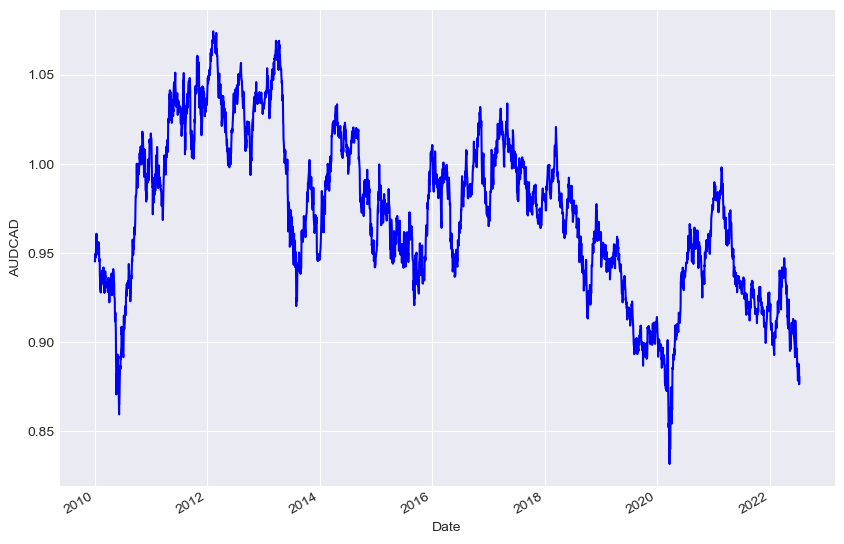

In [3]:
df.Close.plot(figsize=(10,7),color='b')
plt.ylabel('AUDCAD')
plt.show()

## Perform ADF Test

In [4]:
# to Perform ADF test
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df.Close, maxlag = 1)

# Getting the ADF Test Statistic
print('The ADF Test Statistic is :', round(adf[0],2))
print('_'*125)

# Getting the Critical Values

print("The Critical Values are : ", adf[4])
print("_"*125)

The ADF Test Statistic is : -2.58
_____________________________________________________________________________________________________________________________
The Critical Values are :  {'1%': -3.4323531972725316, '5%': -2.862425093278735, '10%': -2.567241153905792}
_____________________________________________________________________________________________________________________________


With 95% confidence we can say that the time series is stationary. Hence, we can use this instrument for Mean Reversion

# Coding the Strategy

## Moving Averages and Moving Standard Deviation

In [5]:
# Moving Averages
df['Moving_Average'] = df.Close.rolling(5).mean()
# Moving Standard Deviation
df['Moving_Std_Dev'] = df.Close.rolling(5).std()

## Upper Band and Lower Band

In [6]:
# Upper Band
df['Upper_Band'] = df['Moving_Average'] + (0.5* df['Moving_Std_Dev'])

# Lower Band
df['Lower_Band'] = df['Moving_Average'] - (0.5 * df['Moving_Std_Dev'])

## Long Entry and Exit

In [7]:
df['Long_Entry'] = df.Close < df.Lower_Band
df['Long_Exit'] = df.Close >= df.Moving_Average

## Long Positions

In [8]:
df['Long_Positions'] = np.nan
df.loc[df.Long_Entry, "Long_Positions"]=1
df.loc[df.Long_Exit,"Long_Positions"]=0

## Forward Fill Long Positions

In [9]:
df.Long_Positions = df.Long_Positions.fillna(method='ffill')

## Short Positions

In [10]:
# Short Entry and Exit
df['Short_Entry'] = df.Close>df.Upper_Band
df['Short_Exit'] = df.Close <= df.Moving_Average

df['Short_Positions'] = np.nan
df.loc[df.Short_Entry, "Short_Positions"] = -1
df.loc[df.Short_Exit, "Short_Positions"] = 0

# Forward Fill Short Positions
df.Short_Positions = df.Short_Positions.fillna(method='ffill')

## Positions

In [11]:
df['Positions'] = df.Long_Positions + df.Short_Positions

## Cumulative Returns

In [12]:
df['Percentage_Returns'] = df.Close.pct_change()
df['Strategy_Returns'] = df.Positions.shift(1) * df.Percentage_Returns
df['Cumulative_returns'] = (df.Strategy_Returns + 1).cumprod()

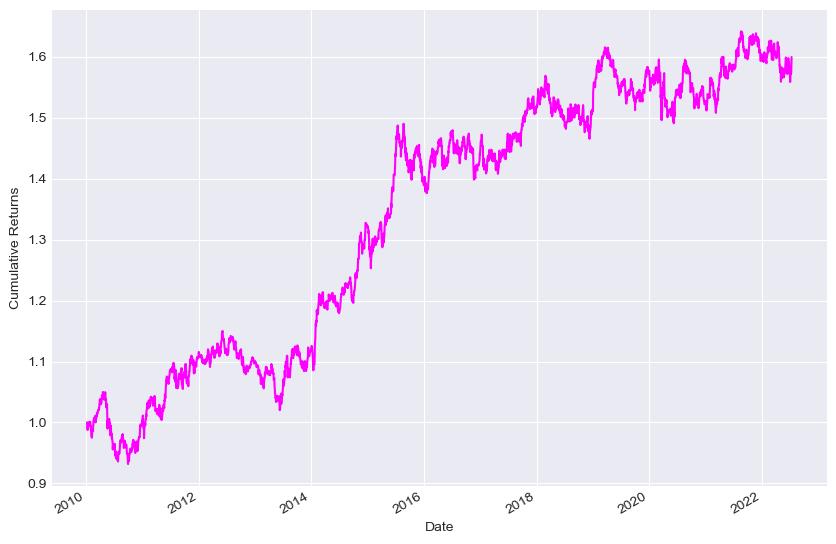

In [13]:
df.Cumulative_returns.plot(label ='Cumulative Returns', figsize =(10,7), color ='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

## Calculating Drawdown

In [14]:
def calc_drawdown(cum_rets):
    # function to Calculate the running maximum Drawdown
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensuring the values never drop below 1
    running_max[running_max <1] = 1
    # Calculate Percentage Drawdown
    drawdown = (cum_rets)/running_max -1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize =(10,7))
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown,color='red')
    plt.grid(which='major',color='k',linestyle='-.',linewidth=0.2)
    plt.show()

The Maximum Drawdown is : -11.290530889293947


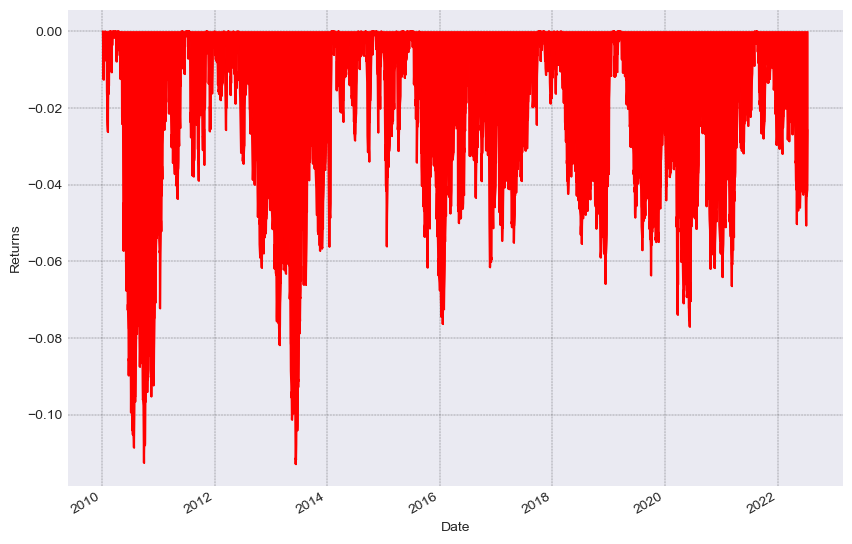

In [15]:
drawdown = calc_drawdown(df.Cumulative_returns)
print('The Maximum Drawdown is :', drawdown.min()*100)
plot_drawdown(drawdown)